# esmIAV
This code looks at interannual variability in the CESM_ESM (prognostic CO2) simulations
- Read in a .nc file using xarray
- Generate annual anomalies in CO2 growth rate


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import SVD_tools as svd
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal
from scipy.stats import spearmanr
import warnings

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

In [2]:
# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# TODO, turn warmings back on with code below? 
#warnings.resetwarnings()

## Read in data

In [3]:
# Point to data
varLND = ['TWS','TBOT','NEE','GPP']  #TWS not available for CESM1 / CLM4
varATM = ['TS','SFCO2','SFCO2_LND']
var = varLND #+ varATM
times = ['195001-199912','200001-201412']

# --- CESM2 hist (1 ensemble member) ---
model = 'CESM2_esm_hist1'
dir_in = '/glade/collections/cdg/timeseries-cmip6/'
case = 'b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001'

# --- CESM1-LENS hist (1 ensemble member) ---
#model = 'CESM1_LENS1'
#dir_in = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'
#case =' b.e11.B20TRC5CNBDRD.f09_g16.001'
#    '{var}/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.{var}.185001-200512.nc'

# Land variables
pattern_lnd0 = dir_in + case + '/lnd/proc/tseries/month_1/'+case+'.clm2.h0.{varLND}'
pattern_lnd1 = [pattern_lnd0.format(varLND = varLND) for varLND in varLND]
# CAM variables
pattern_atm0 = dir_in + case + '/atm/proc/tseries/month_1/'+case+'.cam.h0.{varATM}'
pattern_atm1 = [pattern_atm0.format(varATM = varATM) for varATM in varATM]

# list of strings for each variable & time
fileTWS = [(pattern_lnd1[0]+'.{times}.nc').format(times=times) for times in times]
fileTBOT = [(pattern_lnd1[1]+'.{times}.nc').format(times=times) for times in times]
#fileNBP = [(pattern_lnd1[2]+'.{times}.nc').format(times=times) for times in times]
fileNEE = [(pattern_lnd1[2]+'.{times}.nc').format(times=times) for times in times]
fileGPP = [(pattern_lnd1[3]+'.{times}.nc').format(times=times) for times in times]
fileTS = [(pattern_atm1[0]+'.{times}.nc').format(times=times) for times in times]
fileCO2 = [(pattern_atm1[1]+'.{times}.nc').format(times=times) for times in times]
fileCO2_lnd = [(pattern_atm1[2]+'.{times}.nc').format(times=times) for times in times]


In [4]:
# Read in files
ds_TWS  = utils.time_set_mid(xr.open_mfdataset(fileTWS, decode_times=False, combine='by_coords'), 'time')
ds_TBOT = utils.time_set_mid(xr.open_mfdataset(fileTBOT, decode_times=False, combine='by_coords'), 'time')
ds_NEE  = utils.time_set_mid(xr.open_mfdataset(fileNEE, decode_times=False, combine='by_coords'), 'time')
ds_NEE.NEE.attrs['long_name']= 'Net ecosystem exchange'
ds_GPP  = utils.time_set_mid(xr.open_mfdataset(fileGPP, decode_times=False, combine='by_coords'), 'time')
#ds_NBP  = utils.time_set_mid(xr.open_mfdataset(fileNBP, decode_times=False, combine='by_coords'), 'time')
#ds_NBP.NBP.attrs['long_name']= 'Net biome production'
ds_time = utils.time_set_mid(xr.open_mfdataset(fileTWS, decode_times=True, combine='by_coords'), 'time')

# For CAM output
#ds_TS = utils.time_set_mid(xr.open_mfdataset(fileTS, decode_times=False,combine='by_coords'), 'time')
#ds_CO2 = utils.time_set_mid(xr.open_mfdataset(fileCO2, decode_times=False,combine='by_coords'), 'time')
#ds_CO2_lnd = utils.time_set_mid(xr.open_mfdataset(fileCO2_lnd, decode_times=False,combine='by_coords'), 'time')
#print(ds_CO2.dims)

#ds_TS['lat'] = ds_TWS.lat # make the dimensions identical for merge
#ds_CO2['lat'] = ds_TWS.lat # make the dimensions identical for merge
#ds_CO2_lnd['lat'] = ds_TWS.lat # make the dimensions identical for merge
print('------ Read in data ---------')

------ Read in data ---------


### Merge datasets
- Mask out greenland and antarctic for TWS, TBOT, _as in Humphries paper_
- Calculate anomalies & annual means

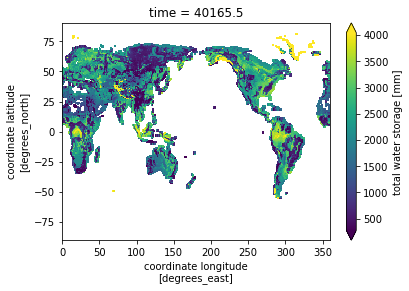

In [5]:
# Merge the datasets
#ds_TWS['TWS'] = ds_TWS.TWS.where(ds_TWS.TWS<=10000)
# ds = xr.merge([ds_TBOT,ds_TWS,ds_NBP,ds_GPP,ds_TS,ds_CO2,ds_CO2_lnd], compat='override')
ds = xr.merge([ds_TBOT,ds_TWS,ds_NEE,ds_GPP], compat='override')

minTWS = 10000
# only mask out land variables
for i in range(len(varLND)):
    #ds[varLND[i]].values = ds[varLND[i]].where(ds_TWS.TWS<=minTWS)
    # here mask out where no GPP instead
    ds[varLND[i]].values = ds[varLND[i]].where(ds_GPP.GPP.max('time')>0)


#SFCO2 kg/m2/s, need to convert to gC/m2/y
#ds['SFCO2'] = ds['SFCO2'] *12/44     
#ds['SFCO2_LND'] = ds['SFCO2_LND'] *12/44     

#subset years after 1960, last 55 years, global trends look linear after this time (except TWS)
years = 55
months = years * 12
ds = ds.isel(time=slice(-months,None))
ds_time = ds_time.time.isel(time=slice(-months,None))
ds.TWS.isel(time=0).plot(robust=True);

In [6]:
%%time 
# calculate anomalies, climatology & get around error w/ esmlab anomaly when decode_times=True 
ds_anom  = esmlab.core.anomaly(ds, clim_freq='mon', time_coord_name='time') 
ds_clim  = esmlab.core.climatology(ds,freq='mon')    # Calculate climatology

ds['time'] = ds_time.time
ds_anom['time'] = ds_time.time
ds_climSD = ds.groupby('time.month').std('time')

# modify chunk sizes for calculating annual means
ds_anom = ds_anom.chunk({'time': 240}) 

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]


CPU times: user 8.52 s, sys: 22.2 s, total: 30.7 s
Wall time: 1min 36s


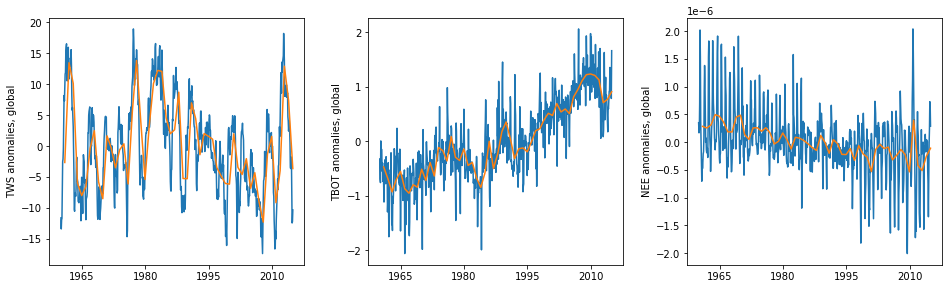

In [7]:
#caclulate annual averages & quickly look at trends
ds_ann_temp = utils.weighted_annual_mean(ds_anom[var[0]])
ds_ann_anom = xr.Dataset( coords={'time': ds_ann_temp.time , "lat": ds_anom.lat, "lon": ds_anom.lon} )

plt.figure(figsize=[16,10])
for i in range(len(var)):
    ds_anom[var[i]].attrs['long_name'] = ds_anom[var[i]].attrs['long_name'] + ' anomaly' 
    ds_ann_anom[var[i]] = utils.weighted_annual_mean(ds_anom[var[i]])
    ds_ann_anom[var[i]].attrs = ds_anom[var[i]].attrs
    # trends after 1960 look good for all but TWS, just make one plot for efficiency here
    if (i<3):  
        plt.subplot(2, 3, (1+i))
        plt.ylabel(var[i] + ' anomalies, global')
        plt.plot(ds_anom.time, ds_anom[var[i]].mean(dim=('lat','lon')))
        plt.plot(ds_ann_anom.time, ds_ann_anom[var[i]].mean(dim=('lat','lon')))
        plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
plt.subplots_adjust(wspace=0.25);

## Weight grid cell fluxes to global sums

In [8]:
# area only for land
lat = ds.lat
lon = ds.lon
nlat = len(lat)
nlon = len(lon)

In [9]:
# NEED to calculate grid areas for atm results
# From Katie's Weighted Means example
R = 6.37e6
# we know already that the spacing of the points is 4 degrees latitude, 5 degrees longitude
dϕ = np.deg2rad(180/nlat)
dλ = np.deg2rad(360/nlon)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))

#dA.where(ds.TS.isel(time=0).notnull())
#pixel_area = dA.where(ds.TS.isel(time=0).notnull())
#pixel_area.attrs['units'] = 'm2'
#pixel_area.attrs['long_name'] = 'grid area'

# print(pixel_area)
# pixel_area.plot(robust=True);

# for weighting in globalSum function, below
land_up = (ds.area.isel(time=0) * ds.landfrac.isel(time=0)) #km^2
land_wgt = land_up / land_up.sum(dim=('lat','lon'))
land_area = land_up.values * 1e6  # convert km2 to m2
#pixel_wgt = pixel_area / pixel_area.sum()

### used in the EOF code, maybe not needed
# focus on vegetated grid cells, keep time dimension here
#temp = ds.GPP.where(ds.GPP.max('time') > 0)
#temp.isel(time=0).plot(robust=True)
#area2 = ds.area.isel(time=0).where(ds.NBP.max('time') > 0)
#l_ar2 = area2 * ds.landfrac.isel(time=0)
#print(l_ar2)
#l_wt2 = l_ar2 / l_ar2.sum(dim=('lat','lon'))


## Define function for global mean

In [10]:
# need to remove the stonrg annual cycle 
# positive flux = source to atmosphere
s2y = 3600 * 24 * 365

def globalSum ( varIn, area, time, conversion, units ):
    "Global weighted sum of fluxes & states"
    temp = varIn * area * time
    temp = temp.sum(dim=('lat','lon'))  * conversion
    temp.attrs['long_name']= varIn.attrs['long_name']
    temp.attrs['units']= units
    #temp = temp.assign_coords({'time': (ds.time)})
    return (temp)

For each variable:
    ['TWS', 'TBOT', 'NEE', 'GPP', 'TS', 'SFCO2', 'SFCO2_LND']
    
Create lists of input needed fro globalSum function: 
    [varIn, area, time, conversion, units]

starting TWS
starting TBOT
starting NEE
starting GPP


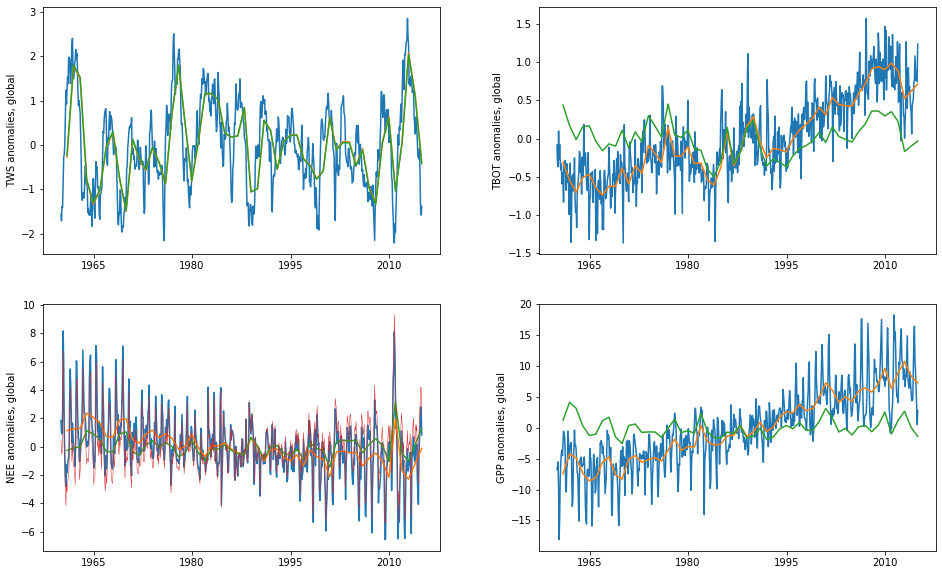

In [11]:
Area = [land_area, land_wgt, land_area, land_area]#, pixel_wgt, pixel_area, pixel_area]
Time = [1, 1, s2y, s2y]#, 1, s2y, s2y]   
## 1 mm water = 1 kg/m2,  1e-15 for kg to Tt,  1e-15 gC to PgC, 1e-12 kgC to PgC
Conversion = [1e-15, 1, 1e-15, 1e-15]#, 1, 1e-12, 1e-12]   
Units = ['Tt $\mathregular{H_2O}$', 'K', 'PgC $\mathregular{y^{-1}}$','PgC $\mathregular{y^{-1}}$']
#        'K', 'PgC $\mathregular{y^{-1}}$', 'PgC $\mathregular{y^{-1}}$']

plt.figure(figsize=[16,10])

# Create datasets for results.  Anomalies # detrended
anom = xr.Dataset( coords={'time': ds_anom.time} )
ann_anom = xr.Dataset( coords={'time': ds_ann_anom.time} )
anom_dt = xr.Dataset( coords={'time': ds_anom.time} )
ann_anom_dt = xr.Dataset( coords={'time': ds_ann_anom.time} )
#then loop through variables
for i in range(len(var)):
    print('starting ' +var[i])
    anom[var[i]] =  globalSum(ds_anom[var[i]], area = Area[i], time = Time[i], 
                                 conversion = Conversion[i], units = Units[i] )
    ann_anom[var[i]] =  globalSum(ds_ann_anom[var[i]], area = Area[i], time = Time[i], 
                                     conversion = Conversion[i], units = Units[i] )
    # detrended results
    anom_dt[var[i]] = xr.DataArray(signal.detrend(anom[var[i]]), dims='time')
    ann_anom_dt[var[i]] = xr.DataArray(signal.detrend(ann_anom[var[i]]), dims='time')
    # copy attributes
    anom_dt[var[i]].attrs = anom[var[i]].attrs
    ann_anom_dt[var[i]].attrs = ann_anom[var[i]].attrs
    
    if (i<6):
        plt.subplot(2, 2, (1+i))
        plt.ylabel(var[i] + ' anomalies, global')
        plt.plot(anom.time, anom[var[i]])
        plt.plot(ann_anom.time, ann_anom[var[i]])
        plt.plot(ann_anom_dt.time, ann_anom_dt[var[i]])
        plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
        if (i == 2) :
            plt.plot(anom.time, anom_dt[var[i]], lw=0.5)

plt.subplots_adjust(wspace=0.25);

#### Still significant trend in monthly C flux anomalies 
## Plot correlations in annual fluxes vs. climate

In [12]:
from scipy import signal,stats
from sklearn.linear_model import LinearRegression

# Generate a function for making panel plots of maps
def map_function(X, Y):#cb=0, cmap=None, ax=None, title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    x= X.values
    y= Y.values
    y2 = y#np.where(y<10, y, np.nan)
    model = LinearRegression().fit(x.reshape((-1, 1)), y2)
    R = np.round(stats.pearsonr(x,y)[0],2)
    slope = np.round(model.coef_,2)[0]

    xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
    yPred = model.predict(xRange)
    yRange= np.array([y.min(),y.max()]).reshape(-1, 1)
    #print(yRange)
    xlim=xRange*1.1
    ylim=yRange*1.
    plt.plot(x, y,'o')
    plt.plot(xRange,yPred)
    plt.text(xlim[1]*0.3,ylim[0]*0.9,'r = '+str(R),fontsize=12, color='k')
    plt.text(xlim[1]*0.3,ylim[0]*0.75,'slope = '+str(slope),fontsize=12, color='k');
    plt.xlim(xlim)
    #plt.ylim(-4.2,3.5)
    plt.ylabel(Y.attrs['long_name']+' ('+Y.attrs['units']+')')
    plt.xlabel(X.attrs['long_name']+' ('+X.attrs['units']+')')
        

 SD annual NEE anomalies* = 0.714 Pg C y^-1 *omitting outlier


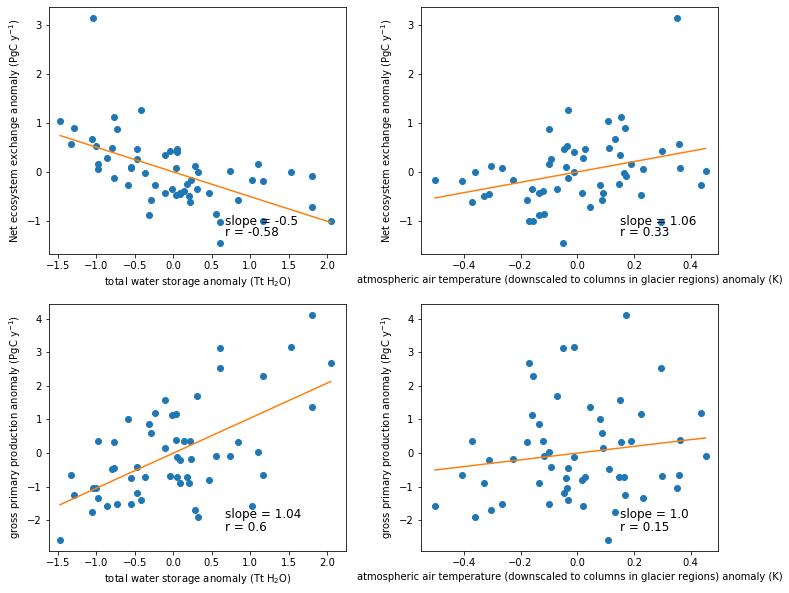

In [13]:
#var_flux = ('SFCO2','SFCO2_LND','NBP','GPP')
var_flux = ('NEE','GPP')

plt.figure(figsize=[12,10])

for i in range(len(var_flux)) :        
    plt.subplot(len(var_flux), 2, (2*i+1))
    map_function(ann_anom_dt.isel(time=slice(0,None)).TWS, ann_anom_dt.isel(time=slice(0,None))[var_flux[i]])
    plt.subplot(len(var_flux), 2, (2*i+2))
    map_function(ann_anom_dt.isel(time=slice(0,None)).TBOT, ann_anom_dt.isel(time=slice(0,None))[var_flux[i]])

plt.subplots_adjust(wspace=0.25);
print(' SD annual NEE anomalies* = ' +
      str(np.round(ann_anom_dt.NEE.where(ann_anom_dt.NEE>-3).std().values,3))+ 
      ' Pg C y^-1 *omitting outlier')

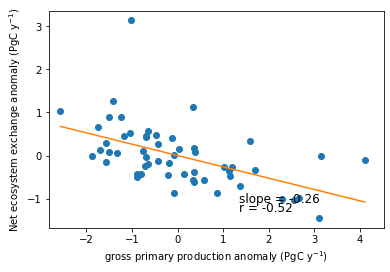

In [14]:
map_function(ann_anom_dt.isel(time=slice(0,None)).GPP, ann_anom_dt.isel(time=slice(0,None)).NEE)

## Plot time series of results

<Figure size 1152x360 with 0 Axes>

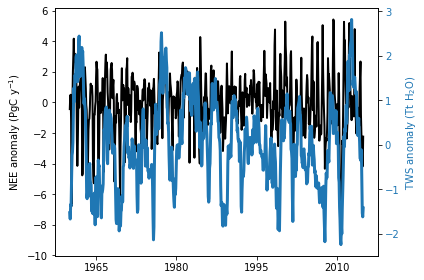

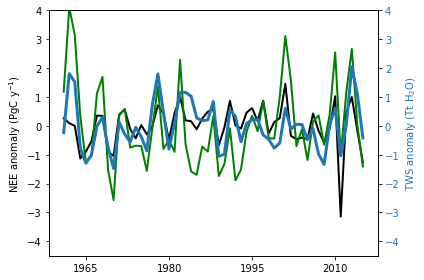

In [15]:
# still seems to have trend in monthly anomalies
plt.figure(figsize=[16,5])

fig, ax1 = plt.subplots()
vPlot = var[2]
color = 'k'
ax1.set_ylabel(vPlot+' anomaly ('+anom_dt[vPlot].attrs['units']+')',color=color)
ax1.plot(anom_dt.time, -anom_dt[vPlot], '-', color=color, lw=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('TWS anomaly ('+anom_dt.TWS.attrs['units']+')',color=color)
ax2.plot(anom_dt.time, anom_dt.TWS, '-', color=color, lw=3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show();


# ---------------
fig, ax1 = plt.subplots()
ylim = [-4.5, 4]
plt.ylim(ylim)
color = 'k'
ax1.set_ylabel(vPlot+' anomaly ('+ann_anom_dt[vPlot].attrs['units']+')',color=color)
ax1.plot(ann_anom_dt.time, -ann_anom_dt[vPlot], '-', color=color, lw=2)
ax1.plot(ann_anom_dt.time, ann_anom_dt['GPP'], '-', color='g', lw=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylim(ylim)
color = 'tab:blue'
ax2.set_ylabel('TWS anomaly ('+ann_anom_dt.TWS.attrs['units']+')',color=color)
ax2.plot(ann_anom_dt.time, ann_anom_dt.TWS, '-', color=color, lw=3)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show();

#plt.plot(ann_anom_dt.time, -ann_anom_dt[vPlot], '-', color='k', lw=2)
#plt.plot(ann_anom_dt.time, ann_anom_dt.TWS, '-', color='tab:blue', lw=3)
#plt.ylabel(vPlot+' anomaly ('+ann_anom_dt[vPlot].attrs['units']+')');

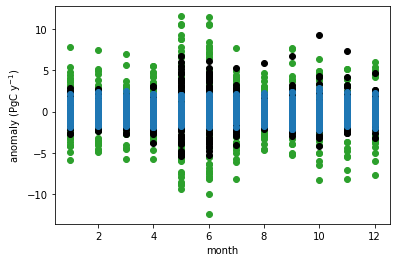

In [16]:
# GPP anomalies largely related to spring GPP 
plt.plot(anom_dt.time['time.month'], anom_dt.GPP, 'o', color='tab:green')
plt.plot(anom_dt.time['time.month'], anom_dt.NEE, 'o', color='k')
plt.plot(anom_dt.time['time.month'], anom_dt.TWS, 'o', color='tab:blue')
plt.ylabel('anomaly ('+ann_anom_dt.NEE.attrs['units']+')')
plt.xlabel('month');

<xarray.DataArray 'GPP' (month: 12)>
array([2.75831242, 2.65508265, 2.43510064, 2.54891183, 5.72527129,
       5.86238897, 3.25996112, 2.21884914, 2.80299275, 2.98452137,
       2.98560742, 2.880782  ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     gross primary production anomaly
    units:         PgC $\mathregular{y^{-1}}$
    cell_methods:  time: mean


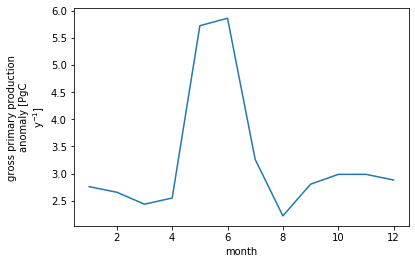

In [17]:
temp = anom_dt.GPP.groupby("time.month").std()
print(temp)
temp.plot();

# Play around with SVD now
* Calculate climatology & seasonal anomalies [ trend already removed ], then
* Reshape for SVD & finally
* Identify amplification vs. early onset vectors
* Determine how SV weights correspond with GPP anomalies (+ or -)

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac
- We dont' need the SV for TBOT and TWS, but we do need seasonal means of detrended anomalies 

In [18]:
# define function to cacluate svd vectors, weights, etc.
# First we have to detrend the data
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (months x year) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [19]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther
def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    # number of vectors in svd = nyears
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon, 'sv': range(nyears) } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'sv', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'sv', 'year'))
    # For clarity, rename dimensions of weights (dim1 = vector#, dim2 = year)
    #                                   vectors (dim1 = vector#, dim2 = month)
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [20]:
%%time
gpp = ds_anom.get('GPP').transpose('time','lat','lon') 
svdGPP = calc_svd(gpp)   
print('----- finished svdGPP -----')

finished svdGPP
CPU times: user 6min 30s, sys: 9.19 s, total: 6min 39s
Wall time: 6min 42s


In [21]:
print(svdGPP)
# rearrange output & write out to scratch
def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('sv','lat','lon')
    out['varfrac'] = out.varfrac.transpose('sv','lat','lon')
    out['vectors'] = out.vectors.transpose('sv', 'time','lat','lon') 
    out['weights'] = out.weights.transpose('sv', 'year','lat','lon')
    ds_clim['time'] = out.time  # get time coords to match
    out['climatology'] = ds_clim.get(var)
    #out.to_netcdf(path='/glade/scratch/wwieder/svd/'+model+'_svd_'+var+'.nc')  
    return out

#this could also be more specific for readability, using 'GPP' instead of var[0]
svdGPP = transpose(svdGPP, 'GPP') 

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, sv: 55, time: 12, year: 55)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv       (sv) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
Dimensions without coordinates: time, year
Data variables:
    theta    (lat, lon, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    varfrac  (lat, lon, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    vectors  (lat, lon, sv, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    weights  (lat, lon, sv, year) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


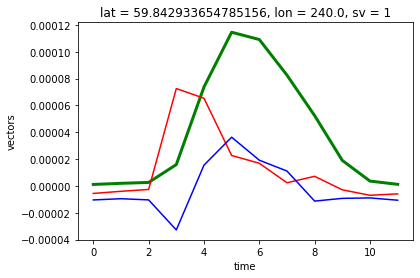

In [22]:
# quick look at results
tlat = 60  #60, 70 #-5  #46  #-3
tlon = 240 #240,30 #300 #262 #280
svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
svdGPP.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot(color='r')
svdGPP.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot(color='b');

### Make plots to visualize results

In [29]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap=None, ax=None, title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(da.lon,da.lat,da.values,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    # allows for different colrobars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

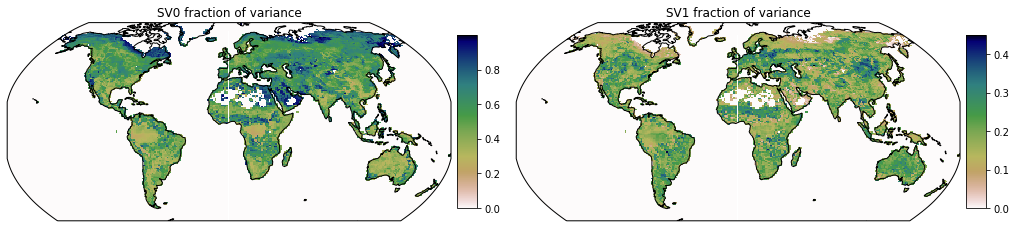

In [30]:
# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = svdGPP.varfrac.isel(sv=index[0])
    map_function(da, ax=ax, title='SV'+str(index[0])+' fraction of variance', 
                  vmax=da.max(), vmin=da.min(), cmap='gist_earth_r',cb=1)

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im,ax=axes.ravel().tolist(), shrink=0.5);
plt.savefig('/glade/scratch/wwieder/svd/'+model+'_GPP_sv_Variance.eps')

## Identify amplificaiton vs. phase shift vectors from correlations w/ GPP climatology
- This will be used to identify SV1 vs. SV2 as amplificaiton vector
- Vectors from SV with highest absolute correlation coefficient = amplification

<xarray.Dataset>
Dimensions:   (sv: 55)
Coordinates:
    lat       float64 59.84
    lon       float64 240.0
  * sv        (sv) int64 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53 54
Data variables:
    pearson   (sv) float64 0.3365 0.8558 0.1456 0.2857 ... nan nan nan nan
    weighted  (sv) float64 0.4112 1.161 0.3279 0.2682 ... nan nan nan nan
    ranked    (sv) float64 0.6993 0.6783 0.2867 0.1259 ... nan nan nan nan


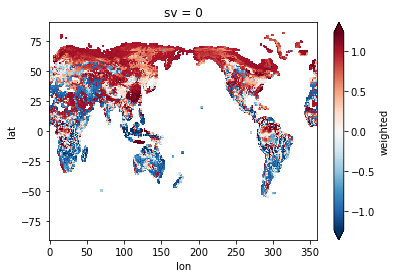

In [39]:
import corrFunc as cor

# Pull off climatology of GPP & calculate weights based on annual cycle
GPPwgt  = svdGPP.climatology / svdGPP.climatology.sum(dim='time') 

dims = dict(zip(ds[var[0]].dims, ds[var[0]].shape))
yx_shape = (dims['lat'], dims['lon'])
# setup output variables

# number of vectors in svd = nyears
corr_shape = (years, ) + yx_shape 
    
GPP_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
GPP_corr['pearson'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['weighted'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['ranked'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))

for i in range(years):
    temp_vector = svdGPP.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = cor.pearson_correlation(svdGPP.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = cor.pearson_correlation_wgt(svdGPP.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = cor.spearman_correlation(svdGPP.climatology, temp_vector, 'time')

print(GPP_corr.sel(lat=tlat, lon=tlon, method='nearest'))
GPP_corr.weighted[0,:,:].plot(robust=True);
#GPP_corr.weighted.sel(lat=tlat, lon=tlon, method='nearest')

negative correlations suggest that some vectors will have to be flipped to match climatology

In [43]:
#GPPwgt.sum(dim='time').plot();

In [28]:
# Mask values to isolate regions with amplificaiton vs. phase shift 
# here using weighted correlation, but also could use ranked 
mask_shape = (2, ) + yx_shape
sv_mask = xr.Dataset( coords={'sv_type': ['amplification','phase shift'] , "lat": ds.lat, "lon": ds.lon} )
sv_mask['ranked'] = xr.DataArray(np.zeros(mask_shape), dims=('sv_type','lat', 'lon'))
sv_mask['ranked'][0,...] = xr.ufuncs.fabs(GPP_corr.ranked[0,...]) >= \
                           xr.ufuncs.fabs(GPP_corr.ranked[1,...])  
sv_mask['ranked'][1,...] = xr.ufuncs.fabs(GPP_corr.ranked[1,...]) > \
                           xr.ufuncs.fabs(GPP_corr.ranked[0,...])  

sv_mask['weighted'] = xr.DataArray(np.zeros(mask_shape), dims=('sv_type','lat', 'lon'))
sv_mask['weighted'][0,...] = xr.ufuncs.fabs(GPP_corr.weighted[0,...]) >= \
                             xr.ufuncs.fabs(GPP_corr.weighted[1,...])  
sv_mask['weighted'][1,...] = xr.ufuncs.fabs(GPP_corr.weighted[1,...]) > \
                             xr.ufuncs.fabs(GPP_corr.weighted[0,...])  

print(sv_mask['weighted'].sel(lat=tlat, lon=tlon, method='nearest') )

<xarray.DataArray 'weighted' (sv_type: 2)>
array([0., 1.])
Coordinates:
    lat      float64 59.84
    lon      float64 240.0
  * sv_type  (sv_type) object 'amplification' 'phase shift'


#### Make plots of grids that are dominated by amplification or phase shift vectors

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  # Remove the CWD from sys.path while we load stuff.


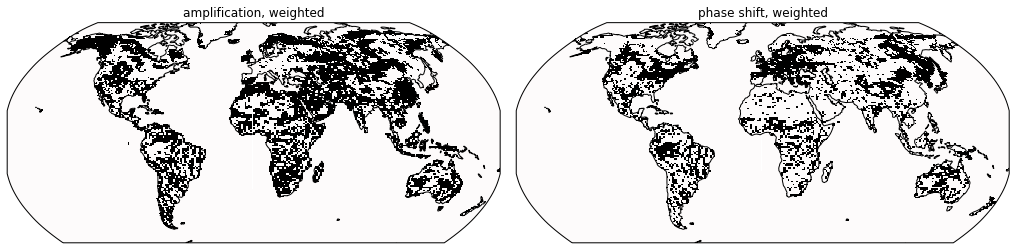

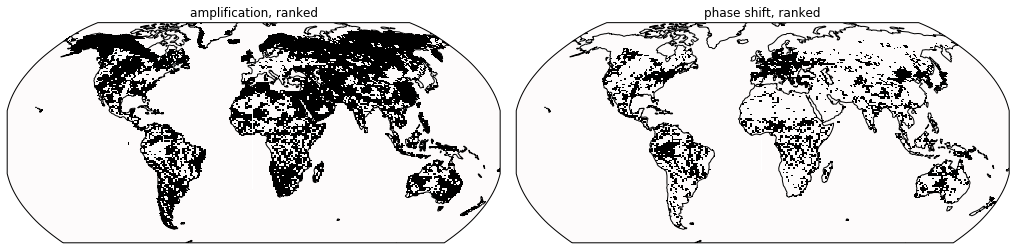

In [45]:
corType = ['weighted', 'ranked']

for i in range(2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                             subplot_kw=dict(projection=ccrs.Robinson()))
    for index, ax in np.ndenumerate(axes):
        da = sv_mask[corType[i]].isel(sv_type=index[0])
        map_function(da, ax=ax, title=str(sv_mask.sv_type[index[0]].values)+', '+corType[i], 
                     cmap='gist_earth_r')
        plt.savefig('/glade/scratch/wwieder/svd/'+model+'_GPP_'+corType[i]+'Vectors.eps')

#### Phase shift mainly in agricutrulal regions & temperate decid. forest

### Use seasonal correlations to determine where to flip SVD vector and weights

## ----- Correlate SV weights w/ seasonal anomalies -----
* Calculate seasonal means of detrended data
* Reshape anomaly vectors to season x year array
* Correlate GPP SV1 weights w/ seasonal GPP anomalies & 
* Reverse / flip weights where needed
* Calculate correlation for GPP SV1 weights w/ seaonal climate anomalies

In [46]:
# Define functiion to handle detrending
def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})


# Build datastet to hold results
dims = dict(zip(ds_anom.get(var[0]).dims, ds_anom.get(var[0]).shape))
out_shape = (dims['lat'], dims['lon'], 4, years)
seasonID = xr.DataArray([12,3,6,9], dims='season') # seasonal time slices
seasonName = xr.DataArray(['DJF','MAM','JJA','SON'], dims='season') # can coords be a string?
yearID   = xr.DataArray(np.unique(ds_anom.time['time.year']), dims='year')
dt_anom  = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )
# set up another dataset for raw data that gets detrended
dt_raw   = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, season: 4, year: 55)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2010 2011 2012 2013 2014
Data variables:
    TWS      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TBOT     (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NEE      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GPP      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0


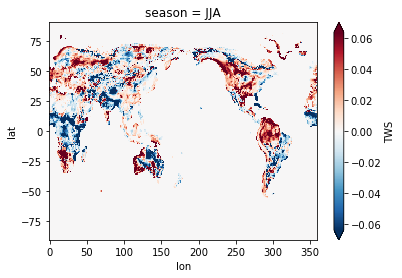

In [47]:
# loop over variables
for v in range(len(var)):
    dt_anom[var[v]] = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    dt_raw[var[v]]  = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    
    # Detrend data at each grid cell
    dt   = dtrend(ds_anom.get(var[v]).load().fillna(0), 'time')
    dt_r = dtrend(ds.get(var[v]).load().fillna(0), 'time')

    # Caculate seasonal means from detrended data
    dt_season = dt.resample(time="QS-DEC").mean().isel(time=slice(0,-1))
    dt_season_raw = dt_r.resample(time="QS-DEC").mean().isel(time=slice(0,-1))

    # now reshape to season * year
    for m in range(len(seasonID)):
        temp = dt_season.where(dt_season.time['time.month']==seasonID[m], drop=True)
        temp_raw = dt_season_raw.where(dt_season_raw.time['time.month']==seasonID[m], drop=True)

        dt_anom[var[v]][:,:,m,:] = temp
        dt_raw[var[v]][:,:,m,:] = temp_raw
        
dt_anom = dt_anom.transpose('season','year','lat','lon')
dt_raw  = dt_raw.transpose( 'season','year','lat','lon')
dt_anom.TWS.isel(season=2).mean(dim='year').plot(robust=True);
dt_SD = dt_raw.std(dim='year') # calculates SD of detrended data across seasons for each year  
dt_anomSD = dt_anom.std(dim='year') # calculates SD of detrended anomalies across seasons for each year  
print(dt_anom)

In [49]:
# Correlation of SVD weights with detrended seasonal anomalies 
# Function loops over each variable (4), SV (2), & season (4)
def corr_wrap(anom, svd):
    da = anom.to_array() 
    dims = dict(zip(da.dims, da.shape))
    corr_shape = (2,dims['season'], dims['lat'], dims['lon'])

    # setup output variables
    corr = xr.Dataset( coords={'sv': range(2), 'season':seasonName, 
                               "lat": ds.lat, "lon": ds.lon} )

    for v in range(len(var)):     # variables
        corr[var[v]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','season','lat', 'lon'))

        # loop through to calculate correlation coef.
        for i in range(2):         # vectors
            for j in range(len(seasonName)): # seasons
                return_vals = cor.pearson_correlation(anom.get(var[v]).isel(season=j), 
                                                  svd['weights'].isel(sv=i), 'year')
                corr[var[v]][i,j,...] = return_vals
        
    return corr

In [50]:
# Create correlation matrix of detrended anomalies with SVD weights
# first make year dimensions indential
svdGPP['year'] = dt_anom.get('year')
svdGPP_corr = corr_wrap(dt_anom, svdGPP) #correlation 

### Identify season with highest correlation to SVD weights

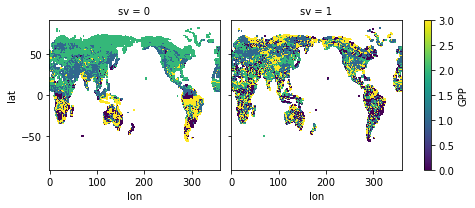

In [51]:
# xr.ufuncs.fabs calculates the absolute value for an xarray object
# argmax picks the index of the largest value across a dimension.
gppMask = svdGPP_corr.GPP.max(dim='season') # mask out oceans
maxGPP_season = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(gppMask.notnull())
simple = maxGPP_season.plot(x='lon', y='lat', col='sv', col_wrap=2);

<xarray.DataArray 'GPP' (sv: 2)>
array([nan, nan])
Coordinates:
    lat      float64 59.84
    lon      float64 240.0
  * sv       (sv) int64 0 1


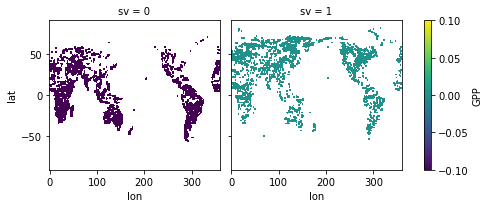

In [55]:
#use same logic to identify points with negative correlation between GPP anomalies and SVD weights 
corType = 'weighted'
flipMask = svdGPP_corr.GPP.min(dim='season').where(gppMask.notnull()) 
maxGPP_abs = xr.ufuncs.fabs(svdGPP_corr.GPP).max(dim='season').where(gppMask.notnull())
flipMask = flipMask + maxGPP_abs
flipMask = flipMask.where(flipMask==0, np.nan)
#flipMask.isel(sv=0).plot()
maxGPP_flip = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(flipMask.notnull())
##simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);
#print(flipMask.sel(lat=tlat, lon=tlon, method='nearest'))

# Only flip the vectors and weights associated with amplification vectors
maxGPP_flip[0,:,:] = flipMask[0,:,:].where(sv_mask[corType].isel(sv_type=0)==1,np.nan)
maxGPP_flip[1,:,:] = flipMask[1,:,:].where(sv_mask[corType].isel(sv_type=1)==1,np.nan)
simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);
#maxGPP_flip = maxGPP_flip.where(maxGPP_flip<=0, 1)
print(maxGPP_flip.sel(lat=tlat, lon=tlon, method='nearest'))

### Flip amplification vectors when correlations w/ seasonal anomalies are negative

In [57]:
## create new datasets that don't change the orig. results
svd2 = svdGPP.copy(deep=True) 
#print(maxGPP_flip.notnull().sel(lat=tlat, lon=tlon, method='nearest'))
for i in range(2):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(maxGPP_flip[i,...].notnull()==False, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(maxGPP_flip[i,...].notnull()==False, -1*svd2.weights[i,...])

### Flip phase shift SV when month of min vector come before max vector

<xarray.DataArray 'vectors' (sv: 55)>
array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
    lat      float64 59.84
    lon      float64 240.0
  * sv       (sv) int64 0 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53 54
<xarray.DataArray 'weighted' (sv_type: 2)>
array([0., 1.])
Coordinates:
    lat      float64 59.84
    lon      float64 240.0
  * sv_type  (sv_type) object 'amplification' 'phase shift'


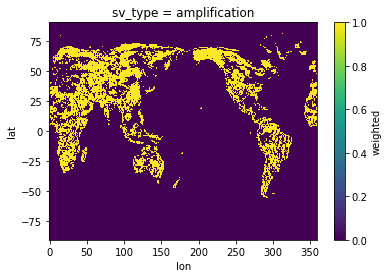

In [58]:
# Still need a better way to think about flipping early phase vectors where needed...
# currently selects when minimum month comes before max & reverses early shift SV
max_vector = svd2.vectors.argmax(dim='time') 
min_vector = svd2.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
flip_vector[0,:,:] = flip_vector[0,:,:].where(sv_mask[corType].isel(sv_type=1)==1,0)#.where(sv_mask[corType].isel(sv_type=1),0)
flip_vector[1,:,:] = flip_vector[1,:,:].where(sv_mask[corType].isel(sv_type=1)==0,0)
print(flip_vector.sel(lat=tlat, lon=tlon, method='nearest'))
print(sv_mask[corType].sel(lat=tlat, lon=tlon, method='nearest') )
sv_mask[corType].isel(sv_type=0).plot()

for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_vector[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_vector[i,...] <= 0, -1*svd2.weights[i,...])

### Reindex over time for sv vectors & climatology for SH to match hydrologic year

In [59]:
idx = [6,7,8,9,10,11,0,1,2,3,4,5]
svdSH = svdGPP.copy(deep=True)
svdSH = svdSH.reindex(time=idx)
svdSH['time'] = svd2.time
svd2['climatology'] = svd2.climatology.where(svd2.lat>=0, svdSH.climatology)
svd2['vectors'] = svd2.vectors.where(svd2.lat>=0, svdSH.vectors)

In [60]:
# use argmax to identify dominant vector type
SVtype = ['amplification','phase shift'] 
temp = (sv_mask[corType].argmax(dim='sv_type').sel(lat=tlat, lon=tlon, method='nearest').values)
print(temp)
print(SVtype[temp])

1
phase shift


In [85]:
def plotQuick(tlat, tlon):
    col = ['r','b']
    temp = (sv_mask[corType].sel(lat=tlat, lon=tlon, method='nearest').values[0])
    #print(temp)
    if (temp == 1): 
        labels=("Climatology", ('SV1 '+SVtype[0]), ('SV2 '+SVtype[1]) )
        legend =("SV1 ~ JJA GPP anomalies", "SV2 ~ MAM GPP anomalies", 'SV2 ~ JJA anomalies')
    else: 
        labels=("Climatology", ('SV1 '+SVtype[1]), ('SV2 '+SVtype[0]) )
        legend =("SV1 ~ MAM GPP anomalies", "SV2 ~ JJA GPP anomalies", 'SV1 ~ JJA anomalies')

    plt.figure(figsize=[15,4])

    plt.subplot(131)
    svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
    for i in range(2):
        svdGPP.vectors.isel(sv=i).sel(lat=tlat, lon=tlon, method='nearest').plot(color=col[i])
    plt.legend(labels=labels);
    plt.title('SVD tlat='+str(tlat)+' tlon='+str(tlon))
    plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))

    plt.subplot(132)
    svd2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
    for i in range(2):
        svd2.vectors.isel(sv=i).sel(lat=tlat, lon=tlon, method='nearest').plot(color=col[i])
    plt.title('reshaped SVD vectors')
    plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))

    plt.subplot(133)
    if tlat>=0:
        if (temp == 1): season = [2,1] #first vector = amplification
        else: season = [1,2] 

        for i in range(2):
            plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=season[i]),
                     svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=i), '*', color=col[i])

        if (temp == 1): 
            plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
                     svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='k')
        else: 
            plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
                     svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='k')

        plt.legend(labels=legend)
    else:
        plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=3),
                 svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
        plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
                 svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
        plt.legend(labels=("SV1 ~ SON GPP anomalies","SV2 ~ MAM GPP anomalies"))
    
    plt.ticklabel_format(axis='x', style='', scilimits=(-2,2))
    plt.title('SVD weights ~ GPP anomalies');
    plt.xlabel('GPP seasonal anomalies (gC/m2/s)')
    plt.ylabel('GPP SV weights');
    #print(svd2.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0))

    plt.subplots_adjust(wspace=0.25);

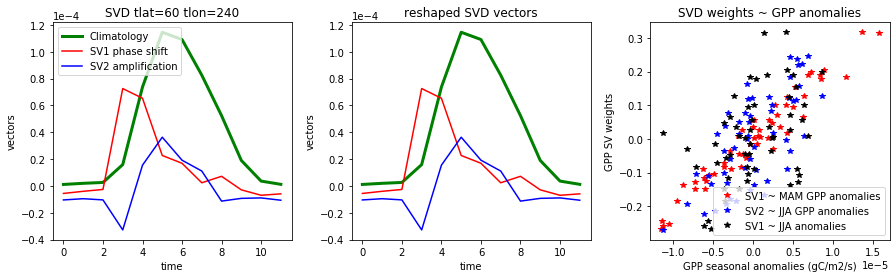

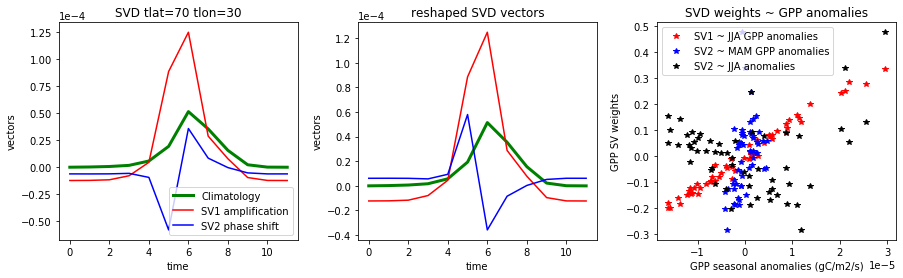

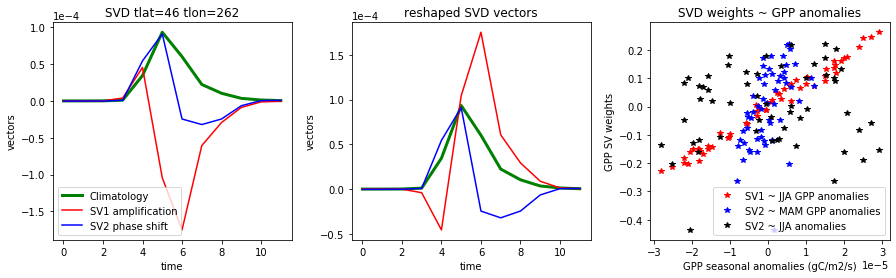

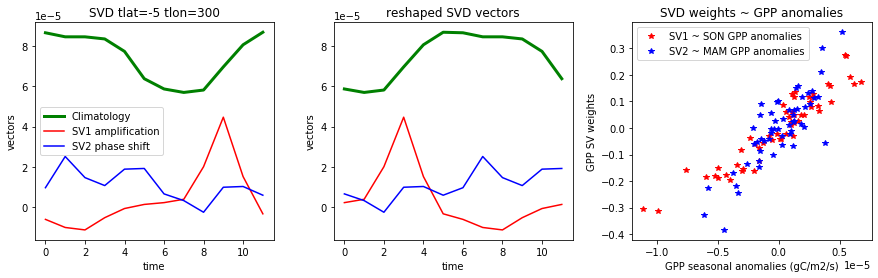

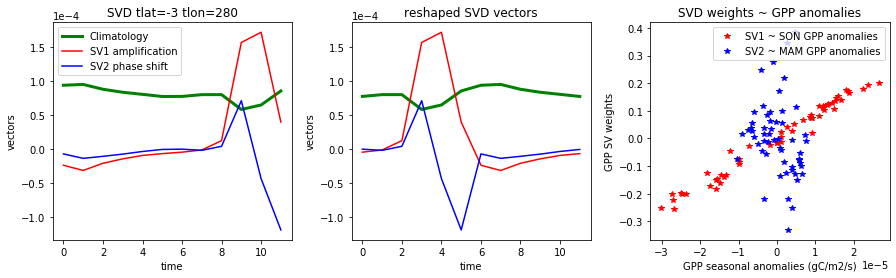

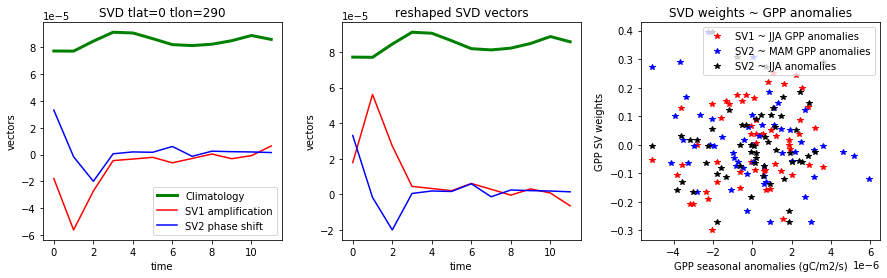

In [86]:
# quick look at results
tlat = [60 , 70,  46,  -5,  -3, 0]
tlon = [240, 30, 262, 300, 280, 290]
for i in range(len(tlat)):
    plotQuick(tlat = tlat[i] ,tlon = tlon[i])

### Weights of SV1 well correlated seasonal GPP anomalies 
#### Repeat correlation between monthly climatology and SV vectors

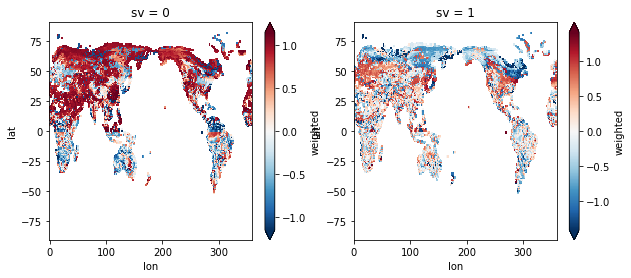

In [87]:
for i in range(years):
    temp_vector = svd2.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = cor.pearson_correlation(svd2.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = cor.pearson_correlation_wgt(svd2.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = cor.spearman_correlation(svd2.climatology, temp_vector, 'time')

plt.figure(figsize=[10,4])
for i in range(2):
    plt.subplot(1,2,(i+1))
    GPP_corr[corType][i,:,:].plot(robust=True);

#### This seems to work for amplitude vectors & early phase vectors in SH and NH
#### Requires reindexing time vectors for SH climatology & vectors to reflect hydrologic cycle

In [88]:
# Plot First and Second Singular Vectors
# Made this long plotting routine into a function

def monthly_plots(ds_all, ds0, ds1, a, b, nA,nB,multi = 0.5e4, save=True ):
    
    fig = plt.figure(4,figsize=(6,4.5))
    barwidth = 0.2
    month = np.arange(12)
    multi = multi       #This is a totally arbitrary scale factor, decided by me, to make figures look good!
    ymax=np.max(ds0.vectors.values)

    # --- GPP, SVD 1 & 2 for regions in phase with GPP 
    vectors2plot=ds0.vectors*multi  
    mm2plot = ds_all.climatology
    ax1 = fig.add_subplot(1,2,1)

    if b > 0:
        ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax1.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'darkgray',linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'darkgray',linewidth=3)

    ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
    ax1.axhline(-0.05,color='black')
    ax1.axhline(0.35,color='black')
    ax1.set_xticks(np.array(month)+2*barwidth)
    ax1.set_yticks([-0.05,0.35])
    ax1.set_yticklabels(['SV2','SV1'])
    ax1.set_ylim([-0.2,0.65])

    ax1.text(0.5,.52,str(int(ds0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[0])+
             "\nn="+str(nA))
    ax1.text(0.5,.15,str(int(ds0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[1]))
    ax1.title.set_text('GPP '+str(a)+"-"+str(b)+", amplification")
    ax1.text(4,-0.29,'Month')

    # ----- Make second panel, where SV1 = phase shift ----
    vectors2plot=ds1.vectors*multi  
    ax2 = fig.add_subplot(1,2,2)

    if b > 0:
        ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax2.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'darkgray',linewidth=3)#,alpha=0.3)
    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'darkgray',linewidth=3)#,alpha=0.3)

    ax2.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
    ax2.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
    ax2.axhline(-0.05,color='black')
    ax2.axhline(0.35,color='black')
    ax2.set_xticks(np.array(month)+2*barwidth)
    ax2.set_yticks([-0.05,0.35])
    ax2.set_yticklabels(['SV2','SV1'])
    ax2.set_ylim([-0.2,0.65])

    ax2.text(0.5,.52,str(int(ds1.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[0])+
             "\nn="+str(nB))
    ax2.text(0.5,.15,str(int(ds1.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[1]))
    ax2.title.set_text('GPP '+str(a)+"-"+str(b)+", early phase")
    ax2.text(4,-0.29,'Month')
    
    if (save == True):
        plt.savefig('/glade/scratch/wwieder/svd/'+model+'_SV_GPP_lat_'+str(a)+'-'+str(b)+'.eps') ;
    else:
        plt.tight_layout()  # Doesn't print to screen as intended

    ax1.remove()
    ax2.remove()

In [ ]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, JH, How do I save plots for each lat band invidually?
# It would be nice to put these all in one figure & or visualize plots here

#a = [50, 20,-20,-50]  # Min lat, -20 to 10 for Amazon
#b = [80, 50, 20, -20]   # Max lat
a = [50, 20,  0,-20,-50]  # Min lat, -20 to 10 for Amazon
b = [80, 50, 20,  0, -20]   # Max lat
#a = [50, 20]
#b = [80, 50]
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 

for i in range(len(a)):
    print('starting plot ' + str(i) )
    svd_plot = svd2
    mean_svd_plot = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon'))
    # -- Amplitude vector --
    mean_svd_plotA = svd_plot.where(sv_mask[corType].isel(sv_type=0)).sel(
        lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    countSetA = sv_mask[corType].isel(sv_type=0).sel(lat=slice(a[i],b[i]), lon=slice(c,d))
    nA = countSetA.where(countSetA>0).count().values
    # -- Phase shift vector -- 
    mean_svd_plotB = svd_plot.where(sv_mask[corType].isel(sv_type=1)).sel(
        lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    countSetB = sv_mask[corType].isel(sv_type=1).sel(lat=slice(a[i],b[i]), lon=slice(c,d))
    nB = countSetB.where(countSetB>0).count().values
          
    monthly_plots(mean_svd_plot,mean_svd_plotA,mean_svd_plotB, a=a[i], b=b[i],nA=nA,nB=nB)   

starting plot 0
starting plot 1
starting plot 2
starting plot 3
starting plot 4


In [ ]:
sv_mask[corType].isel(sv_type=1).plot(robust=True);


In [ ]:
# make plots for regions as in Buermann et al. 2018 
a = [50, 50 ]  # siberia = 60-70N, 80-120E
b = [60, 60 ]  # W US    = 40-50N, 105-120W, here W canada instead
c = [125, 230]  
d = [160,270]  
for i in range(len(a)):
    svd_plot = svd2
    mean_svd_plot = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c[i],d[i])).mean(('lat','lon'))
    # -- Amplitude vector --
    mean_svd_plotA = svd_plot.where(sv_mask[corType].isel(sv_type=0)).sel(
        lat=slice(a[i],b[i]), lon=slice(c[i],d[i])).mean(('lat','lon')) 
    countSetA = sv_mask[corType].isel(sv_type=0).sel(lat=slice(a[i],b[i]), lon=slice(c[i],d[i]))
    nA = countSetA.where(countSetA>0).count().values
    # -- Phase shift vector -- 
    mean_svd_plotB = svd_plot.where(sv_mask[corType].isel(sv_type=1)).sel(
        lat=slice(a[i],b[i]), lon=slice(c[i],d[i])).mean(('lat','lon')) 
    countSetB = sv_mask[corType].isel(sv_type=1).sel(lat=slice(a[i],b[i]), lon=slice(c[i],d[i]))
    nB = countSetB.where(countSetB>0).count().values
          
    monthly_plots(mean_svd_plot,mean_svd_plotA,mean_svd_plotB, a=c[i], b=d[i],nA=nA,nB=nB)

    

### Seems to:
* Appropriately identify SV1 as amplification or early phase vectors
* SV1 explians good deal varriation (at least for high & mid latitudes)
* SV2 of phase shift = amplificaiton!
* maybe additional work needed for tropics?

# ----- Correlate SV weights w/ seasonal anomalies -----
* Calculate seasonal means of detrended data
* Reshape anomaly vectors to season x year array
* Correlate GPP SV1 weights w/ seasonal GPP anomalies & 
* Reverse / flip weights where needed
* Calculate correlation for GPP SV1 weights w/ seaonal climate anomalies

In [ ]:
# Define functiion to handle detrending
def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})


# Build datastet to hold results
dims = dict(zip(ds_anom.get(var[0]).dims, ds_anom.get(var[0]).shape))
out_shape = (dims['lat'], dims['lon'], 4, years)
seasonID = xr.DataArray([12,3,6,9], dims='season') # seasonal time slices
seasonName = xr.DataArray(['DJF','MAM','JJA','SON'], dims='season') # can coords be a string?
yearID   = xr.DataArray(np.unique(ds_anom.time['time.year']), dims='year')
dt_anom  = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )
# set up another dataset for raw data that gets detrended
dt_raw   = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )

# loop over variables
for v in range(len(var)):
    dt_anom[var[v]] = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    dt_raw[var[v]]  = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))

    dt   = dtrend(ds_anom.get(var[v]).load().fillna(0), 'time')
    dt_r = dtrend(ds.get(var[v]).load().fillna(0), 'time')

    dt_season = dt.resample(time="QS-DEC").mean().isel(time=slice(0,-1))
    dt_season_raw = dt_r.resample(time="QS-DEC").mean().isel(time=slice(0,-1))
    # now reshape
    for m in range(len(seasonID)):
        temp = dt_season.where(dt_season.time['time.month']==seasonID[m], drop=True)
        temp_raw = dt_season_raw.where(dt_season_raw.time['time.month']==seasonID[m], drop=True)

        dt_anom[var[v]][:,:,m,:] = temp
        dt_raw[var[v]][:,:,m,:] = temp_raw
        
dt_anom = dt_anom.transpose('season','year','lat','lon')
dt_raw  = dt_raw.transpose( 'season','year','lat','lon')
dt_anom.TWS.isel(season=2).mean(dim='year').plot(robust=True);
dt_SD = dt_raw.std(dim='year') # calculates SD of detrended data across seasons for each year  
dt_anomSD = dt_anom.std(dim='year') # calculates SD of detrended anomalies across seasons for each year  
print(dt_SD)

In [ ]:
# calculate z-score, which will normalize for differences in SD of raw data
# z = anomaly / sigma (here done for each season)

dt_Z = dt_anom / dt_SD
print(dt_Z)
dt_Z.GPP.isel(season=2, year=21).plot(robust=True);

In [ ]:
#svd2['year'] = dt_anom.get('year')
#dt_Z['year'] = dt_anom.get('year')
#svd2_corr = corr_wrap(dt_anom, svd2) # correlation of anomalies with modified (flipped SVD results)
#svd2_Zcorr = corr_wrap(dt_Z, svd2)

In [ ]:
# quick look at results
tlat = 60  #60, 70 #-5  #46  #-3
tlon = 240 #240,30 #300 #262 #280
svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
svd2.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot(color='r')
svd2.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot(color='b');


In [ ]:
# Results look at example from single grid cell, with 
# GPP_sv weights ~ seasonal anomalies 
# sv1 Early shift = spring & sv2 Amplificaton = summer
if tlat>=0:
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), 'o', color='k')
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper left',labels=("SV1 weights ~ MAM GPP anomalies",
                                         "SV1 weights ~ JJA GPP anomalies",
                                         "SV2 weights ~ JJA GPP anomalies"));
else:
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=3),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper right',labels=("SV1 weights ~ SON GPP anomalies",
                                         "SV2 weights ~ MAM GPP anomalies"))

plt.xlabel('GPP seasonal anomalies (gC/m2/s)')
plt.ylabel('GPP SV weights');
#print(svd2.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0))

In [ ]:
# Results look at example from single grid cell, with 
# GPP_sv weights ~ z-score of seasonal anomalies 
# sv1 Early shift = spring & sv2 Amplificaton = summer

if tlat>=0:
    plt.plot(dt_Z.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_Z.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper left',labels=("SV1 weights ~ MAM GPP z-score",
                                         "SV2 weights ~ JJA GPP z-score"));
else:
    plt.plot(dt_Z.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=3),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
    plt.plot(dt_Z.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
             svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
    plt.legend(loc='upper left',labels=("SV1 weights ~ SON GPP z-score",
                                         "SV2 weights ~ MAM GPP z-score"))

plt.xlabel("GPP seasonal z-score anomalies")
plt.ylabel('GPP SV weights');
#print(svd2.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0))

#### Weights typically have have the same sign as GPP anomalies
* But not always in tropics
* Do we need to reverse vectors and weights where this negative correlation exists?
* We'll try this in a bit

### Now look for correlations for GPP sv weights & GPP anomalies
* this will be used to flip weights for sv1 as needed

In [ ]:
# Create correlation matrix
# first make year dimensions indential
svd2['year'] = dt_anom.get('year')
dt_Z['year'] = dt_anom.get('year')

svd2_corr = corr_wrap(dt_anom, svd2) # correlation of anomalies with modified (flipped SVD results)
svd2_Zcorr = corr_wrap(dt_Z, svd2)

In [ ]:
print(svdGPP)
# --- Check that results ar sensible ---
# GPP SV1 coorelated with JJA GPP anomalies in NH, as expected
# GPP SV1 coorelated with MAM GPP anomalies in early shift regions (NE USA + Ag.) 
for i in range(2):
    simple = svd2_corr.GPP.isel(sv=i).plot(x='lon', y='lat', col='season', col_wrap=4)
#svd2_corr.GPP.isel(sv=0, season=2).plot(robust=True);

Weights do not necessarily have the same sign as GPP anomalies
(e.g. see Amazon in plots above & below)
- Itentify season with maximum abs(correlation) between SV weights & GPP anomalies
- Reverse vectors and weights where this value < 0
- repeat correlation matrix

In [ ]:
svdGPP_corr = corr_wrap(dt_anom, svdGPP) #correlation of anomalies with raw SVD results

# xr.ufuncs.fabs calculates the absolute value for an xarray object
# argmax picks the index of the largest value across a dimension.
gppMask = svdGPP_corr.GPP.max(dim='season') # mask out oceans
maxGPP_season = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(gppMask.notnull())
simple = maxGPP_season.plot(x='lon', y='lat', col='sv', col_wrap=2);
#    svd2_corr.GPP.isel(sv=i).plot(x='lon', y='lat', col='season', col_wrap=4)
#    maxGPP_season.isel(sv=0).plot(robust=True);

#use same logic to identify points with negative correlation between GPP anomalies and SVD weights 
maxGPP_flip = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(gppMask<0)
#maxGPP_flip = maxGPP_flip.where(maxGPP_flip<=0, 1)
simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);

#maxGPP_flip.isel(sv=1).plot(robust=True);

## create new datasets that don't change the orig. results
svd2 = svdGPP.copy(deep=True) 
for i in range(2):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(maxGPP_flip[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(maxGPP_flip[i,...] <= 0, -1*svd2.weights[i,...])
    

In [ ]:
#use same logic to identify points with negative correlation between GPP anomalies and SVD weights 
maxGPP_flip = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(gppMask<0)
maxGPP_flip = maxGPP_flip.where(maxGPP_flip<=0, 1)
simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);

#maxGPP_flip.isel(sv=1).plot(robust=True);

In [ ]:
## create new datasets that don't change the orig. results
svd2 = svdGPP.copy(deep=True) 
for i in range(2):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(maxGPP_flip[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(maxGPP_flip[i,...] <= 0, -1*svd2.weights[i,...])
    

In [ ]:
print(maxGPP_season.sel(lat=tlat, lon=tlon, method='nearest'))
print((tuple(svdGPP_corr.GPP.season)))
temp = svdGPP_corr.GPP.isel(season=maxGPP_season)
print(temp)

### Next should look at environmental correlations in dominant seasons
cor.svd[weights] ~ TBOT and TWS anomalies


In [ ]:
## simplify correlations to look at values only when 
# weights from SV most strongly correlate with seasonal GPP anomalies

# 1) set up dataset to hold results
max_season_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
max_season_SD   = xr.Dataset( coords={"lat": ds.lat, "lon": ds.lon} )
max_season_wgt  = xr.Dataset( coords={'year':dt_anom.year, "lat":dt_anom.lat, "lon":dt_anom.lon} )
max_season_Z    = xr.Dataset( coords={'year':dt_anom.year, "lat":dt_anom.lat, "lon":dt_anom.lon} )

for i in range(len(var)):
    max_season_corr[var[i]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
    max_season_SD[var[i]]   = xr.DataArray(np.zeros(yx_shape), dims=('lat', 'lon'))
    max_season_wgt[var[i]]  = xr.DataArray(np.zeros((years, dims['lat'], dims['lon'])), 
                                           dims=('year','lat', 'lon'))
    max_season_Z[var[i]]  = xr.DataArray(np.zeros((years, dims['lat'], dims['lon'])), 
                                           dims=('year','lat', 'lon'))

print(max_season_SD)
# 2) loop through vectors and seasons
# write out corr coefficients where maxGPP_seaon == T
for i in range(2):         # vectors
      for j in range(len(seasonName)): # seasons
            for k in range(len(var)):
                max_season_corr.get(var[k])[i,...] = svd2_corr.get(var[k])[i,j,...].where(maxGPP_season[i,...]==j, 
                                                                                             max_season_corr.get(var[k])[i,...])
                max_season_SD[var[k]] = dt_anomSD.get(var[k])[j,...].where(maxGPP_season[0,...]==j,
                                                                           max_season_SD.get(var[k]))
                max_season_wgt[var[k]] = dt_anom.get(var[k])[j,...].where(maxGPP_season[0,...]==j,
                                                                           max_season_wgt.get(var[k]))
                max_season_Z[var[k]] = dt_Z.get(var[k])[j,...].where(maxGPP_season[0,...]==j,
                                                                           max_season_Z.get(var[k]))

#convert C flux anomalies to gC/m2/d 
max_season_wgt['GPP'] = max_season_wgt.GPP * 3600 * 24 
max_season_SD['GPP'] = max_season_SD.GPP * 3600 * 24 
max_season_wgt['NEE'] = max_season_wgt.NEE * 3600 * 24 
max_season_SD['NEE'] = max_season_SD.NEE * 3600 * 24 

max_season_SD.GPP.plot();

In [ ]:
# use xarray facet plots for pannels
# each row show correlations between SV_1 weights and seasonal anomalies
for k in range(len(var)):
    simple = svd2_corr[var[k]].isel(sv=0).plot(x='lon', y='lat', col='season', col_wrap=4)
    
plt.savefig('/glade/scratch/wwieder/svd/'+model+'_'+var[k]+'multi_summary.eps')

In [ ]:
var2 = ['maxGPP_season']+['GPP','TWS','TBOT']
print(var2)

In [ ]:
# -- first add season of max correlation of SV weights with GPP anomalies to dataset being plotted
max_season_corr['maxGPP_season'] = maxGPP_season
max_season_SD['maxGPP_season'] = maxGPP_season.isel(sv=0)   
var2 = ['maxGPP_season']+['GPP','TWS','TBOT']
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0)
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1


# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im,ax=axes.ravel().tolist(), shrink=0.5);
plt.savefig('/glade/scratch/wwieder/svd/'+model+'_'+var2[1]+'_summary.eps')
    

### Grids characterized by early phase SV1 also have higher % varriation explianted by soil water SV

In [ ]:
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

svType = 1
i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0).where(sv_mask[corType].isel(sv_type=svType))
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal ['+str(sv_mask.sv_type[svType].values)+'] '+var2[i]+' anomalies '
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1

In [ ]:
print(sv_mask.sv_type[0].values)

In [ ]:
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0)
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        #cmap = colors.ListedColormap(['r', 'g', 'b', 'c'])
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1
    

### Makes more sense to correlate anomalies or z-score directly?
#### use ufunc to to apply linear regression & save output


In [ ]:
# output = slope, intercept, r, p, SE
def reg3d(x, y):
    reg = xr.apply_ufunc(scipy.stats.linregress, x, y,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,  dataset_join='exact')
    return reg

reg_shape = (2,5, ) + yx_shape
types = ['anomaly','z-score']
lin_out = ['slope', 'intercept', 'r','p', 'SE']
reg_out = xr.Dataset( coords={'type':types,'lin_reg':lin_out, "lat": ds.lat, "lon": ds.lon} )

for i in range(2):
    reg_out[var[i]] = xr.DataArray(np.zeros(reg_shape), dims=('type','lin_reg','lat', 'lon'))
    temp0 = reg3d(max_season_wgt.get(var[i]),max_season_wgt.get('GPP'))
    temp1 = reg3d(max_season_Z.get(var[i]),max_season_Z.get('GPP'))
    # not sure how to get series of 5 arrays into dataset, but this works
    for j in range(5):
        reg_out[var[i]][0,j,...] = temp0[j] 
        reg_out[var[i]][1,j,...] = temp1[j] 

print(reg_out)

In [ ]:
reg_outSig = reg_out.where(reg_out.isel(lin_reg=3)<0.05)
#reg_outSig.TBOT.isel(type=0, lin_reg=0).plot(robust=True);

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
imax = [0.02, 0.5] #slope ranges for TWS, TBOT
imin = [-0.02, -0.5]
for index, ax in np.ndenumerate(axes):
    print(index)
    i = index[0]
    j = index[1]
    da = reg_outSig[var[(j+0)]].isel(lin_reg=2, type=i) #lin_reg 0 = slope, 2 = r
    title='r GPP ~ '+var[(j+0)]+' '+types[i]
    if j == 0:
        cmap='RdBu'
        #cmap='BrBG'
    else:
        cmap='RdBu_r'
    if i == 0:
        vmax=1.
        vmin=-1.
        #vmax=imax[j]
        #vmin=imin[j]
    else:
        vmax=1.
        vmin=-1.

    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)

plt.savefig('/glade/scratch/wwieder/svd/'+model+'_regressionR.pdf')

# unused code, here to work on flipping vectors / weights

In [ ]:
## Code below may not be most appropriate, comment out for now

'''corType = 'weighted'

# This selects amplification vectors, where correlation coef. negative
# reverses weights and vectors for amplitde SVs as needed
flip_corr = 0+(GPP_corr[corType] < 0.)
flip_corr[0,:,:] = flip_corr[0,:,:].where(sv_mask[corType].isel(sv_type=0), 0) 
flip_corr[1,:,:] = flip_corr[1,:,:].where(sv_mask[corType].isel(sv_type=1), 0)
print(flip_corr.sel(lat=tlat, lon=tlon, method='nearest'))
#flip_corr.isel(sv=0).plot()

# Still need a better way to think about flipping early phase vectors where needed...
# currently selects when minimum month comes before max & reverses early shift SV
max_vector = svdGPP.vectors.argmax(dim='time') 
min_vector = svdGPP.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
flip_vector[0,:,:] = flip_vector[0,:,:].where(sv_mask[corType].isel(sv_type=1),0)
flip_vector[1,:,:] = flip_vector[1,:,:].where(sv_mask[corType].isel(sv_type=0),0)
print(flip_vector.sel(lat=tlat, lon=tlon, method='nearest'))

flip_combined = flip_corr + flip_vector 
flip_combined.isel(sv=0).plot()
print(flip_combined.sel(lat=tlat, lon=tlon, method='nearest'))

## create new datasets that don't change the orig. results
svd2 = svdGPP.copy(deep=True) 
for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd2.weights[i,...])'''

# add one more logical for if amplication vectors 
''' NOT USED HERE
# Here if mean vectors < 0 flip vectors & weights for Amp. SV 
flip_amp =  svd2.vectors.mean(dim='time') < 0.
for i in range(2):
    flip_amp[i,:,:] = flip_amp[i,:,:].where(sv_mask[corType].isel(sv_type=i),0)

flip_amp.isel(sv=0).plot(robust=True)
print(svd2.vectors.mean(dim='time').sel(lat=tlat, lon=tlon, method='nearest'))
print(flip_amp.sel(lat=tlat, lon=tlon, method='nearest'))
'''

'''
# select grids where max vector is negative to reverse weights and vector for amp. SV
flip_max =  svd2.vectors.max(dim='time') < 0.
for i in range(2):
    flip_max[i,:,:] = flip_max[i,:,:].where(sv_mask[corType].isel(sv_type=i),0)

flip_max.isel(sv=0).plot(robust=True);
print(svd2.vectors.mean(dim='time').sel(lat=tlat, lon=tlon, method='nearest'))
print(flip_max.sel(lat=tlat, lon=tlon, method='nearest'))


for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_max[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_max[i,...] <= 0, -1*svd2.weights[i,...])

# Now repeat the correlation between vectors and climatology    
'''

'''svd3 = svdGPP.copy(deep=True) 
for i in range(years):
    svd3.vectors[i,...] = svd3.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd3.vectors[i,...])
    svd3.weights[i,...] = svd3.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd3.weights[i,...])'''

## Look at EOFs for spatial information?

In [ ]:
na     = -9999
NEE    = ds_anom.NEE.fillna(na) 
NEE_dt = signal.detrend(NEE, axis=0,type='linear')

# add back in dims and coords
NEE_dt = xr.DataArray(NEE_dt, coords = ds_anom.NEE.coords, dims = ds_anom.NEE.dims, attrs = ds_anom.NEE.attrs)
# add back in missing values
NEE_dt = NEE_dt.where(NEE != na)  
print(NEE_dt)

In [ ]:
%%time 
from eofs.xarray import Eof

In [ ]:
%%time 
# Create an EOF solver to do the EOF analysis. 
# latitude weights are applied before the computation of EOFs.
solverNEE  = Eof(NEE_dt, weights=l_wt2)

In [ ]:
# how much of variance does each EOF describe?  
# not much, all are < 10% (except temperature)
ev = solverNEE.varianceFraction(neigs=3)
print(ev)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input VAR0 anomalies at each grid point, and the
# leading PC time series itself.
eof1_NEE = solverNEE.eofsAsCorrelation(neofs=1)